# Making wavelets

Bruges has implementations of several common wavelets:

- Ricker.
- Ormsby (implemented in time and in frequency, with slightly different features).
- Klauder (aka 'sweep', a good choice for Vibroseismic modeling).
- Berlage (a good choice for marine seimsic shot with an airgun).
- Sinc.
- Gabor.
- Gaussian.

All of the wavelets have these features:

- They return a tuple of 2 arrays by default: the wavelet's amplitudes and the time samples.
- They guarantee an odd-length wavelet.
- They can all take a time array if you want specific time samples instead of a specific time duration.
- They can all take a frequency array (a 2D array for Ormsby and Klauder) providing a range of frequencies in a single two-dimensional wavelet 'bank'. See below for examples.

Let's take a look at examples illustrating some of these features.

## Ricker wavelet

We'll start with the simplest, commonest case: [a Ricker wavelet](https://subsurfwiki.org/wiki/Ricker_wavelet), sometimes called a Mexican Hat wavelet, with its easy-to-understand central frequency.

We pass in three key parameters:

- `duration` &mdash; the total length of the pulse in seconds, e.g. `0.128` for a wavelet 128 ms long.
- `dt` &mdash; the interval between time samples in seconds, e.g. `0.004` for a 250 Hz sample rate.
- `f` &mdash; the dominant frequency of the wavelet in Hertz, eg `25` for a low-frequency pulse.

Let's make one and plot it:

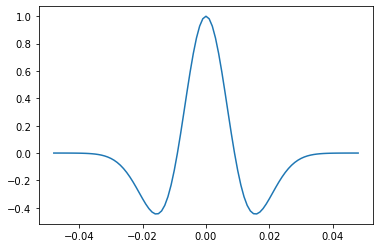

In [1]:
import matplotlib.pyplot as plt
import bruges as bg

w, t = bg.filters.ricker(duration=0.096, dt=0.001, f=25)

plt.plot(t, w)

Easy right? 

Let's annotate the plot a bit so you can see exactly what's going on:

Text(0.5, 1.0, 'Ricker wavelet, 25 Hz')

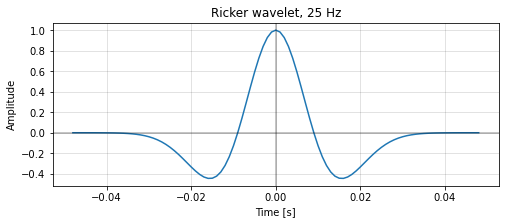

In [2]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, w)
ax.grid(c='k', alpha=0.15, lw=0.75)
ax.axhline(0, c='k', alpha=0.3)
ax.axvline(0, c='k', alpha=0.3)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.set_title('Ricker wavelet, 25 Hz')

The wavelet has an odd number of samples. In general, filters should have odd length, otherwise you have to deal with time shifts when the filter acts on your data.

Both `w` and `t` are NumPy arrays, so we can easily get information about them:

In [3]:
w.shape

(97,)

## A bank of Rickers

Passing a range of frequencies results in a range of wavelets, compiled into a 2D array. Let's make a bank with frequencies from 4 to 48 Hz in steps of 2 Hz:

In [4]:
import numpy as np

freqs = np.arange(4, 50, step=2)

freqs

array([ 4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36,
       38, 40, 42, 44, 46, 48])

In [5]:
w, t = bg.filters.ricker(duration=0.096, dt=0.001, f=freqs)

w.shape

(23, 97)

It makes the most sense to plot this 2D array as an image:

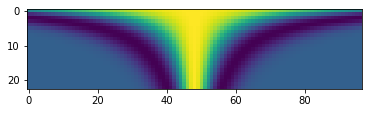

In [6]:
plt.imshow(w)

Again, let's embellish it a bit for clarity:

Text(0.5, 1.0, 'Bank of Ricker wavelets')

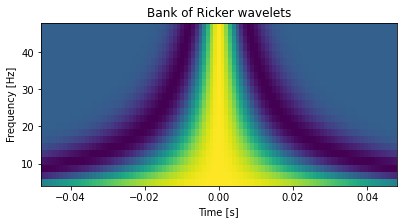

In [7]:
extent = [t[0], t[-1], freqs[0], freqs[-1]]

fig, ax = plt.subplots(figsize=(8, 3))
ax.imshow(w, extent=extent, aspect=0.001, origin='lower')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title('Bank of Ricker wavelets')

## Ormsby wavelet

The Ormsby wavelet is broader band and therefore a bit more realistic than the Ricker wavelet for most modern datasets. (Ormsby wavelets have a trapezoidal spectrum, whereas that of the Ricker is Gaussian.)

You need to specify four frequencies when defining an Ormsby wavelet: the low-cut, the low-pass, the high-pass, and the high-cut. Together, these define a trapezoidal spectrum. 

Here's an example: 

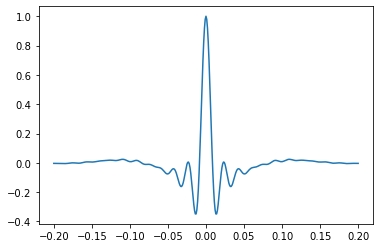

In [8]:
w, t = bg.filters.ormsby(duration=0.4, dt=0.001, f=[4, 8, 45, 60])

plt.plot(t, w)

Compared to Rickers, these wavelets need to be rather long in order to accommodate the longers wavelengths. 

## Ormsby FFT

There's a second implementation of the Ormsby wavelet that allows you to define a different shape. Instead of the spectrum having a flat top, you can give it 'colour' (more or lower or higher frequencies) by providing two extra values for the power of the f<sub>2</sub> and f<sub>3</sub> frequencies, given in relative dB:

![Ormsby vs Ormsby FFT](../_static/ormsby-vs-ormsby_fft.png)

The powers of f<sub>1</sub> and f<sub>4</sub> are assumed to be minus infinity (a magnitude of 0).

Let's make a wavelet like the previous one, but we'll reduce the power of the higher frequencies by 15 dB:

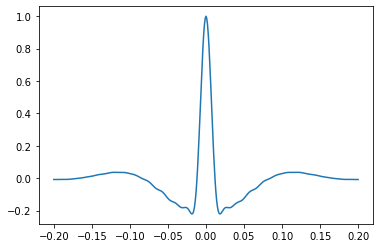

In [9]:
w, t = bg.filters.ormsby_fft(duration=0.400, dt=0.001, f=[4, 8, 45, 60], P=[0, -15])

plt.plot(t, w)

## Klauder wavelet

This is a good choice for simulating Vibroseis data. The wavelet is the autocorrelation of a sweep, such as you might get from a Vibroseis truck.

For this wavelet, you must provide the sweep start and end:

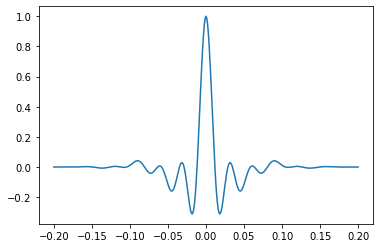

In [10]:
w, t = bg.filters.klauder(duration=0.400, dt=0.001, f=[4, 40])

plt.plot(t, w)

Any other keyword arguments are passed back to [`scipy.signal.chirp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.chirp.html). You may especially want to change:

- `method` &mdash; one of 'linear', 'quadratic', 'logarithmic', or 'hyperbolic'; the shape of the sweep. Default is 'linear'.
- `phi` &mdash; the phase offset, in degrees; default is 0.

Let's look at logarithmic sweep:

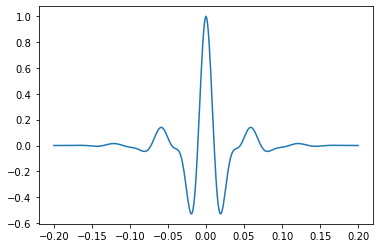

In [11]:
w, t = bg.filters.klauder(duration=0.400, dt=0.001, f=[4, 40], method='logarithmic')

plt.plot(t, w)

## Berlage wavelet

This **minimum phase** wavelet implements David F. Aldridge, (1990), The Berlage wavelet, _GEOPHYSICS_ **55**, 1508-1511, [DOI 10.1190/1.1442799](https://doi.org/10.1190/1.1442799).

It takes a dominant frequency, as well as optional parameters for the time exponent `n`, the exponential decay `alpha`, and the phase of the wavelet `phi` (default: -pi/2).

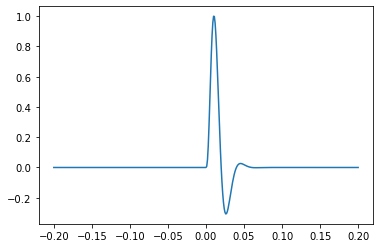

In [12]:
w, t = bg.filters.berlage(duration=0.400, dt=0.001, f=25)

plt.plot(t, w)

## The generalized wavelet

The `generalized` function implements Yanghua Wang (2015), Generalized seismic wavelets, _Geophysical Journal International_ **203** (2), p 1172–1178, https://doi.org/10.1093/gji/ggv346

Here's part of the abstract from that paper, explaining the utility of these wavelets:

> The Ricker wavelet, which is often employed in seismic analysis, has a symmetrical form. Seismic wavelets observed from field data, however, are commonly asymmetric with respect to the time variation. In order to better represent seismic signals, asymmetrical wavelets are defined systematically as fractional derivatives of a Gaussian function in which the Ricker wavelet becomes just a special case with the integer derivative of order 2. 

This fractional derivative parameter, `u`, is 2 by default. So if you don't change it, this function produces a Ricker wavelet:

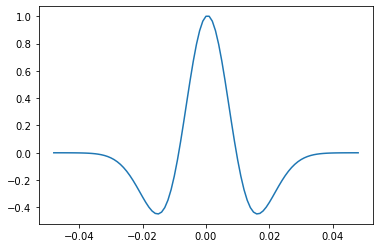

In [13]:
w, t = bg.filters.generalized(duration=0.096, dt=0.001, f=25)

plt.plot(t, w)

Let's change `u` to 1.75:

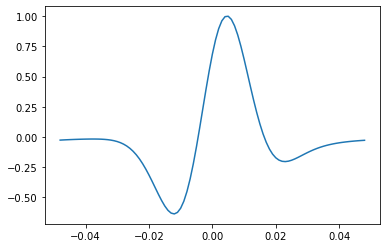

In [14]:
w, t = bg.filters.generalized(duration=0.096, dt=0.001, f=25, u=1.5)

plt.plot(t, w)

This looks a little like a phase rotation, but it's subtly different. Let's compare (but read the paper to find out more).

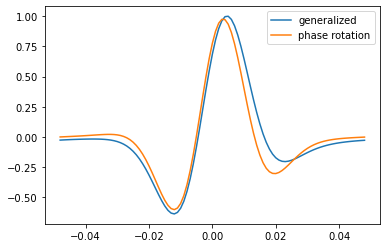

In [15]:
w_0, t = bg.filters.generalized(duration=0.096, dt=0.001, f=25, u=2)
w_rot = bg.filters.rotate_phase(w_0, -0.6)  # radians
plt.plot(t, w, label='generalized')
plt.plot(t, w_rot, label='phase rotation')
plt.legend()

You can also pass an array for `u` to see the full range of wavelets:

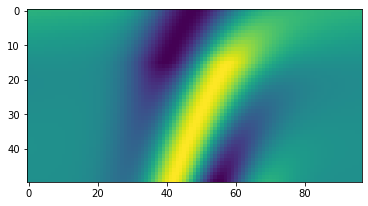

In [16]:
w, t = bg.filters.generalized(duration=0.096, dt=0.001, f=25, u=np.linspace(0.1, 3))

plt.imshow(w)

**Bend your mind!** Pass an array to both and have fun exploring the 3D wavelet bank that results:

In [17]:
freqs = np.arange(4, 81, 2)
us = np.arange(0.1, 3, 0.1)
w, t = bg.filters.generalized(duration=0.096, dt=0.001, f=freqs, u=us)

w.shape

(29, 39, 97)

---
&copy; 2022 Agile Scientific, CC BY